<div style="display:fill;
           background-color:#89B9AD88;
           letter-spacing:0.5px;border-bottom: 2px solid black;">
<img src="https://raw.githubusercontent.com/IqmanS/Machine-Learning-Notebooks/main/mohs_hardness/mohs-banner.jpg">
    
<h1 style="padding: 12px; color:black; font-weight:600;font-family: 'Garamond', 'Lucida Sans', sans-serif; text-align: center; font-size: 32px;text-transform: uppercase;">Regression with Mohs Hardness Dataset</h1>
</div>

In [1]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings("ignore")
import os
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# sns.set_style("dark")
sns.set_palette("viridis")
# sns.color_palette("flare")
from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor
from xgboost.callback import EarlyStopping
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate, StratifiedKFold, RepeatedStratifiedKFold, RepeatedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, median_absolute_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
import optuna
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from catboost import Pool, CatBoostRegressor, cv
import tensorflow as tf
import tensorflow_probability as tfp

<div style="background-color: #89B9AD88; padding: 12px; border-radius: 20px; border: 2px solid black;">
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: black; font-weight: bold; font-size: 32px;">
    📝 Table of Contents
    </h1>
</div>
<br>
<a href="#1" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #183D3D;font-size: 18px;"> 1. Dataset Overview </a><br>
<a href="#2" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #183D3D;font-size: 18px;"> 2. EDA </a><br>
<a href="#3" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #183D3D;font-size: 18px;"> 3. Simple Data Preprocessing </a><br>
<a href="#4" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #183D3D;font-size: 18px;"> 4. Training Models </a><br>
<a href="#4.1" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #183D3D;font-size: 14px;padding-left: 25px;"> 4.1 Baseline RandomForest Model </a><br>
<a href="#4.2" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #183D3D;font-size: 14px;padding-left: 25px;"> 4.2 Baseline CatBoost Model </a><br>
<a href="#4.3" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #183D3D;font-size: 14px;padding-left: 25px;"> 4.3 Baseline LGBM Model </a><br>
<a href="#4.4" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #183D3D;font-size: 14px;padding-left: 25px;"> 4.4 Baseline XGB Model </a><br>
<a href="#4.5" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #183D3D;font-size: 14px;padding-left: 25px;"> 4.5 Voting Regressor </a><br>
<a href="#4.6" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #183D3D;font-size: 14px;padding-left: 25px;"> 4.6 Neural Network based on VR Preds </a><br>
<a href="#6" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #183D3D;font-size: 18px;"> 5. Plotting Feature Importance </a><br>
<a href="#7" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #183D3D;font-size: 18px;"> 6. Creating 'submission.csv' </a><br>
<a href="#8" style="font-family: 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: left; color: #183D3D;font-size: 18px;"> 7. Conclusion </a>

<div id="1" style="background-color: #89B9AD88; padding: 12px; border-radius: 20px; border: 2px solid black;">
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: black; font-weight: bold; font-size: 32;">
   📚 Dataset Overview
    </h1>
</div>

In [2]:
train_data = pd.read_csv("/kaggle/input/playground-series-s3e25/train.csv", index_col="id")
orig_data = pd.read_csv("/kaggle/input/prediction-of-mohs-hardness-with-machine-learning/jm79zfps6b-1/Mineral_Dataset_Supplementary_Info.csv",index_col="Unnamed: 0")
test_data = pd.read_csv("/kaggle/input/playground-series-s3e25/test.csv",index_col="id")

orig_data["Hardness"] = round(orig_data["Hardness"]*2)/2
train_data = pd.concat([train_data,orig_data])

sample = pd.read_csv("/kaggle/input/playground-series-s3e25/sample_submission.csv")
sample["Hardness"] = 0

for col in train_data.columns:
    train_data[col] = train_data[col].astype(np.float32)
for col in test_data.columns:
    test_data[col] = test_data[col].astype(np.float32)

In [3]:
train_data.head(10)

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
0,100.0,0.841611,10.000000,4.800000,20.612526,11.088100,2.766000,1.732000,0.860000,0.496070,0.91457,6.0
1,100.0,7.558488,10.000000,4.800000,20.298893,12.040830,2.755000,1.631000,0.910000,0.492719,0.71760,6.5
2,76.0,8.885992,15.600000,5.600000,33.739258,12.086300,2.828000,1.788000,0.864000,0.481478,1.50633,2.5
3,100.0,8.795296,10.000000,4.800000,20.213348,10.948500,2.648000,1.626000,0.936000,0.489272,0.78937,6.0
4,116.0,9.577996,11.600000,4.800000,24.988132,11.824480,2.766000,1.682000,0.896000,0.492736,1.86481,6.0
5,131.0,24.529327,21.833334,4.666667,50.131500,11.948200,2.858333,1.758333,0.896667,0.466388,2.94712,6.0
6,50.0,3.253996,10.000000,4.800000,20.077019,11.023840,2.727000,1.767000,0.880000,0.499010,0.80631,2.0
7,30.0,2.701748,6.000000,4.000000,11.663548,12.415840,2.766000,1.495000,0.710000,0.618492,0.41631,4.0
8,120.0,14.632000,12.000000,4.800000,24.808517,11.331820,2.870000,1.718500,0.910000,0.492736,1.96268,6.0
9,97.0,13.477328,12.812500,5.000000,24.988132,11.037175,2.818750,1.601250,0.881250,0.493192,1.10889,5.8


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11029 entries, 0 to 630
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   allelectrons_Total     11029 non-null  float32
 1   density_Total          11029 non-null  float32
 2   allelectrons_Average   11029 non-null  float32
 3   val_e_Average          11029 non-null  float32
 4   atomicweight_Average   11029 non-null  float32
 5   ionenergy_Average      11029 non-null  float32
 6   el_neg_chi_Average     11029 non-null  float32
 7   R_vdw_element_Average  11029 non-null  float32
 8   R_cov_element_Average  11029 non-null  float32
 9   zaratio_Average        11029 non-null  float32
 10  density_Average        11029 non-null  float32
 11  Hardness               11029 non-null  float32
dtypes: float32(12)
memory usage: 603.1 KB


In [5]:
train_data.describe()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
count,11029.000000,11029.000000,11029.000000,11029.000000,11029.000000,11029.000000,11029.000000,11029.000000,11029.000000,11029.000000,11029.00000,11029.000000
mean,138.478027,15.245563,16.907728,4.539603,37.210823,10.947921,2.608727,1.727907,0.940243,0.494563,2.12126,4.649074
std,300.368286,18.357166,10.453092,0.698567,25.961319,1.430073,0.339107,0.197129,0.181762,0.065491,1.93760,1.683276
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000
25%,68.000000,7.558488,10.000000,4.000000,20.298893,10.599905,2.530000,1.672500,0.864000,0.476196,0.81244,3.000000
50%,100.000000,11.073071,12.500000,4.700000,26.164726,11.221458,2.706000,1.732000,0.914286,0.489272,1.34593,5.500000
75%,138.000000,17.590000,21.833334,4.800000,48.719501,11.688350,2.805000,1.797812,0.980000,0.496606,2.73200,6.000000
max,15300.000000,643.093811,67.000000,6.000000,167.399994,15.245810,3.443000,2.250000,1.615840,0.825990,10.97000,10.000000


In [6]:
test_data.describe()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average
count,6939.000000,6939.000000,6939.000000,6939.000000,6939.000000,6939.000000,6939.000000,6939.000000,6939.000000,6939.000000,6939.000000
mean,126.460129,14.794020,17.406185,4.546852,38.422791,10.921513,2.608119,1.737907,0.949638,0.491675,2.152066
std,207.564499,18.982447,10.996089,0.683158,27.344351,1.378980,0.322873,0.190584,0.179266,0.060829,1.958212
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,68.000000,7.558488,10.000000,4.000000,20.298893,10.584314,2.527500,1.678000,0.866667,0.476095,0.812440
50%,100.000000,10.650000,12.666667,4.750000,26.203827,11.202760,2.706000,1.736000,0.920000,0.488550,1.351550
75%,128.000000,16.601328,22.000000,4.800000,48.719501,11.645560,2.806667,1.820000,0.990000,0.496119,2.780220
max,10116.000000,643.093811,67.000000,6.000000,167.399994,15.245810,3.443000,2.250000,1.615333,0.825990,10.970000


<div id="2" style="background-color: #89B9AD88; padding: 12px; border-radius: 20px; border: 2px solid black;">
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: black; font-weight: bold; font-size: 32px;">
   📊 Exploratory Data Analysis
    </h1>
</div>

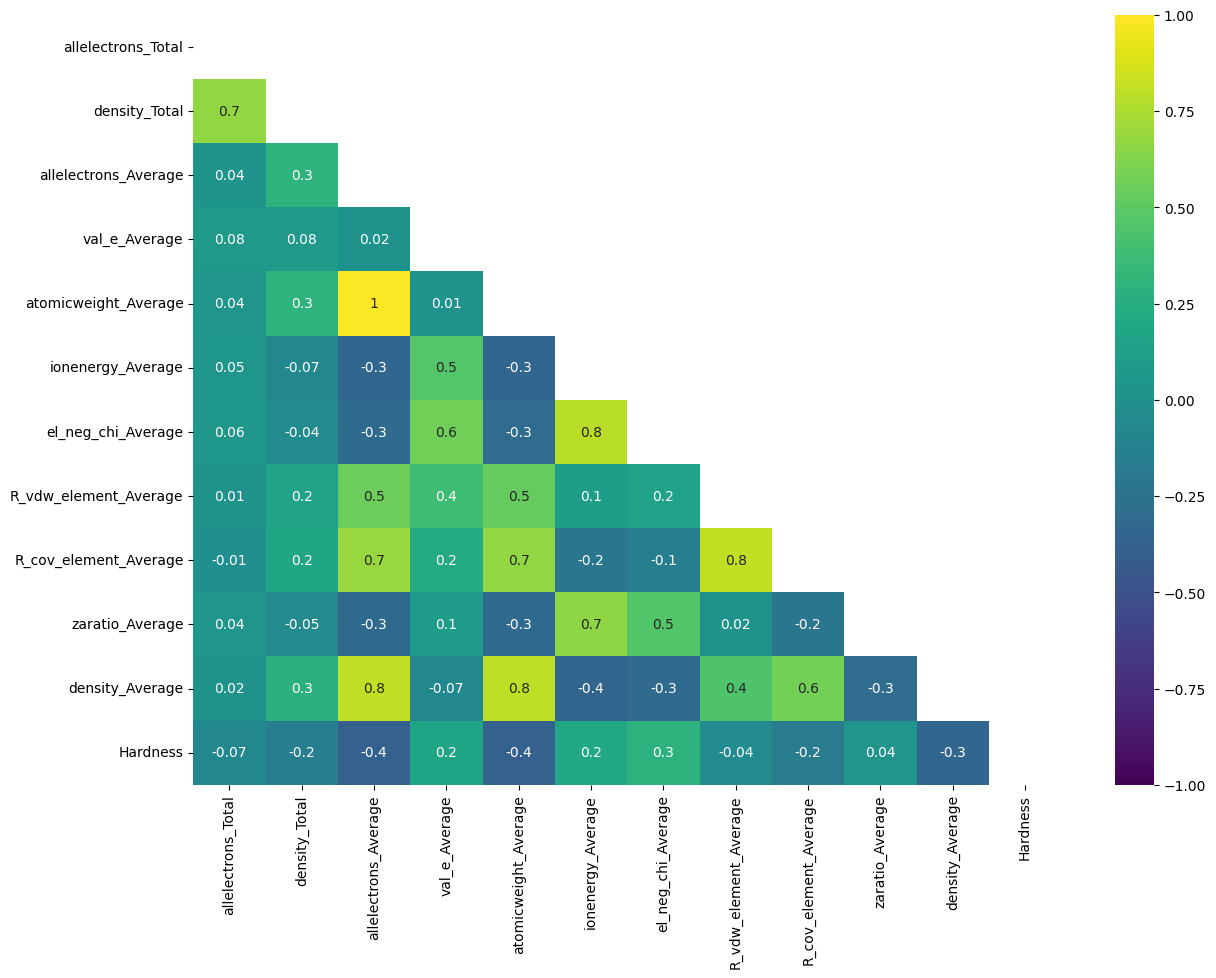

In [7]:
mask = np.triu(np.ones_like(train_data.corr()))
plt.figure(figsize=(14,10))
sns.heatmap(train_data.corr(), cmap="viridis", annot=True, mask=mask,vmin=-1,vmax=1,fmt=".1g");

In [8]:
fig,axes = plt.subplots(12,2,figsize=(15, 40),dpi=300)

for ind,col in enumerate(train_data.columns):
    plt.subplot(12,2,2*ind+1)
    sns.histplot(orig_data[col],bins=15,kde=True)
    plt.gca().set_title(col)
    
    plt.subplot(12,2,2*ind+2)
    sns.boxplot(orig_data[col],orient="h")
    plt.gca().set_title(col)

fig.tight_layout()
plt.show()

<div id="3" style="background-color: #89B9AD88; padding: 12px; border-radius: 20px; border: 2px solid black;">
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: black; font-weight: bold; font-size: 32px;">
   🧪 Simple Data Preprocessing
    </h1>
</div>
<h4 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: left; color: #263A29;font-size: 20px;">
Made the models worse. :(
</h4>


In [9]:

# for i in train_data.columns: 
#     if i=="Hardness":
#         continue
#     Q1 = train_data[i].quantile(0.25)
#     Q3 = train_data[i].quantile(0.75)
#     IQR = Q3-Q1
#     upper_limit = Q3+1.5*IQR
#     lower_limit = Q1-1.5*IQR 
#     print(upper_limit,lower_limit)
#     train_data[i].clip(lower = lower_limit,upper = upper_limit,inplace=True)   
#     test_data[i].clip(lower = lower_limit,upper = upper_limit,inplace=True)

In [10]:
# train_data.describe()

<div id="4" style="background-color: #89B9AD88; padding: 12px; border-radius: 20px; border: 2px solid black;">
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: black; font-weight: bold; font-size: 32px;">
   🤖 Training Models
    </h1>
</div>

In [11]:
seed = np.random.seed(6)

X = train_data.drop(["Hardness"],axis=1)
y = train_data["Hardness"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

<div id="o" >
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: left; color: #263A29; font-weight: normal; font-size: 28px;">Evaluation Metric (Median Abs Error):</h1>
</div>

\begin{align}
MedAE (y,\hat{y}) = median(| y_i - \hat {y}_i |,...,| y_n - \hat {y}_n |)
\end{align}


<div id="4.1" >
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: #263A29; font-weight: bold; font-size: 30px;">
   4.1 Baseline RandomForest Model
    </h1>
</div>
<hr>

In [12]:
rfmodel = RandomForestRegressor(random_state=seed)
rfmodel.fit(X,y)
print("CV MedAE of Baseline RF is",-1*cross_val_score(rfmodel,X,y,cv=4,scoring="neg_median_absolute_error").mean())
print("CV MAE of Baseline RF is",-1*cross_val_score(rfmodel,X,y,cv=4,scoring="neg_mean_absolute_error").mean())

CV MedAE of Baseline RF is 0.6346249958872794
CV MAE of Baseline RF is 0.8871942559807058


<div id="4.2" >
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: #263A29; font-weight: bold; font-size: 30px;">
   4.2 Baseline CatBoost Model
    </h1>
</div>
<hr>

In [13]:
catmodel = CatBoostRegressor(iterations=2500,random_state=seed,verbose=0)
catmodel.fit(X,y)
print("CV MedAE of Baseline Cat is",-1*cross_val_score(catmodel,X,y,cv=4,scoring="neg_median_absolute_error").mean())
print("CV MAE of Baseline Cat is",-1*cross_val_score(catmodel,X,y,cv=4,scoring="neg_mean_absolute_error").mean())

CV MedAE of Baseline Cat is 0.6372363091490572
CV MAE of Baseline Cat is 0.8818695271402335


<div id="4.3" >
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: #263A29; font-weight: bold; font-size: 30px;">
   4.3 LGBM Model
    </h1>
</div>
<hr>

In [14]:
lgbm_params = {'n_estimators': 785, 'max_depth': 36, 'learning_rate': 0.01417471417676199,
               'min_child_weight': 1.1070027262610547, 'min_child_samples': 15,
               'subsample': 0.6061322281791591, 'subsample_freq': 3,
               'colsample_bytree': 0.4174456813911724, 'num_leaves': 55}

lgbmmodel = LGBMRegressor(**lgbm_params,random_state=seed,device="gpu")
lgbmmodel.fit(X,y)
print("CV MedAE of Baseline LGBM is",-1*cross_val_score(lgbmmodel,X,y,cv=4,scoring="neg_median_absolute_error").mean())
print("CV MAE of Baseline LGBM is",-1*cross_val_score(lgbmmodel,X,y,cv=4,scoring="neg_mean_absolute_error").mean())

CV MedAE of Baseline LGBM is 0.6224096516555718
CV MAE of Baseline LGBM is 0.8687477390773457


<div id="4.4" >
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: #263A29; font-weight: bold; font-size: 30px;">
   4.4 XGB Model
    </h1>
</div>
<hr>

In [15]:
xgb_params = {'n_estimators': 887, 'max_depth': 9, 'min_child_weight': 10.170221895950583,
              'learning_rate': 0.008383026974789366, 'subsample': 0.6705032929674755,
              'gamma': 0.6206804342071246, 'colsample_bytree': 0.6811067581297359,
              'colsample_bylevel': 0.8931207102930049, 'colsample_bynode': 0.9326927674256934}

xgbmodel = XGBRegressor(**xgb_params,random_state=seed,tree_method="gpu_hist")
xgbmodel.fit(X,y)
print("CV MedAE of Baseline XGB is",-1*cross_val_score(xgbmodel,X,y,cv=4,scoring="neg_median_absolute_error").mean())
print("CV MAE of Baseline XGB is",-1*cross_val_score(xgbmodel,X,y,cv=4,scoring="neg_mean_absolute_error").mean())

CV MedAE of Baseline XGB is 0.6212031543254852
CV MAE of Baseline XGB is 0.8693142682313919


<div id="4.5" >
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: #263A29; font-weight: bold; font-size: 30px;">
   4.5 Voting Regressor
    </h1>
</div>
<hr>

In [16]:
vrmodel = VotingRegressor([("rf",rfmodel),("cat",catmodel),("lgbm",lgbmmodel),("xgb",xgbmodel)],weights=[1,1,2,2])
vrmodel.fit(X,y)
print("CV MedAE of Voting Regressor is",-1*cross_val_score(vrmodel,X,y,cv=4,scoring="neg_median_absolute_error").mean())
print("CV MAE of Voting Regressor is",-1*cross_val_score(vrmodel,X,y,cv=4,scoring="neg_mean_absolute_error").mean())

CV MedAE of Voting Regressor is 0.6217114177782048
CV MAE of Voting Regressor is 0.8677957169837291


<div id="4.6" >
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: #263A29; font-weight: bold; font-size: 30px;">
   4.6 Neural Network based on VR Preds
    </h1>
    
</div>
<hr>
<h4 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: left; color: #263A29;font-size: 20px;">
Inspired from <a href = "https://www.kaggle.com/code/enricomanosperti/regression-with-a-mohs-hardness-dataset"> this kernel </a>
</h4>

In [17]:
X_nn = X.copy()
X_nn["VR_Preds"] = vrmodel.predict(X)

preds_vr = vrmodel.predict(test_data)
test_data["VR_Preds"] = preds_vr

In [18]:
def loss_fn(y_true, y_pred):
    return tfp.stats.percentile(tf.abs(y_true - y_pred), q=50)

In [19]:
def createModel():
    nnmodel = tf.keras.models.Sequential()
    nnmodel.add(tf.keras.layers.InputLayer(input_shape=(12,)))
    nnmodel.add(tf.keras.layers.Dense(32))
    nnmodel.add(tf.keras.layers.Dense(32))
    nnmodel.add(tf.keras.layers.Dense(1))
    nnmodel.compile(optimizer=tf.keras.optimizers.Adam(0.004),loss=loss_fn,metrics=['mae'])
    return nnmodel

In [20]:
SPLITS = 4
REPEATS = 1
MedAE_score = []
MAE_score = []

early_stopping = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
reduce_LR = tf.keras.callbacks.ReduceLROnPlateau(patience=5, min_lr=0.00001,factor=0.2)
kFold_historys = []

for i,(tr,val) in enumerate(RepeatedKFold(n_splits=SPLITS, n_repeats=REPEATS,random_state=seed).split(X_nn,y)):
    
    print("-"*30,f"FOLD {i+1}/{SPLITS*REPEATS}","-"*30)
    print("> Spliting Data")
    X_train, X_test, y_train, y_test = X_nn.iloc[tr,:],X_nn.iloc[val,:],y.iloc[tr],y.iloc[val]
    print("> Creating New NN Model")
    nnmodel = createModel()
    print("> Training NN Model")
    history = nnmodel.fit(X_train,y_train, epochs=100,
                          callbacks=[early_stopping,reduce_LR],
                          validation_data=(X_test,y_test),
                          verbose=0,shuffle=True) 
    
    kFold_historys.append(history.history)
    print("> Evaluating NN Model")
    MedAE = median_absolute_error(y_test, nnmodel.predict(X_test).flatten())
    MAE = mean_absolute_error(y_test, nnmodel.predict(X_test).flatten())
    MedAE_score.append(MedAE)
    MAE_score.append(MAE)
    print(f"-- Fold {i+1} MedAE of XGB =", MedAE)
    print(f"-- Fold {i+1} MAE of XGB =", MAE)
    print("> Prediction on Test Data")
    sample["Hardness"] += nnmodel.predict(test_data).flatten()
    print()
print("\n\n","-"*50,sep="")
print("CV score of MAE is ",np.array(MAE_score).mean())
print("CV score of MedAE is ",np.array(MedAE_score).mean())

------------------------------ FOLD 1/4 ------------------------------
> Spliting Data
> Creating New NN Model
> Training NN Model
> Evaluating NN Model
87/87 [==============================] - 0s 1ms/step
-- Fold 1 MedAE of XGB = 0.39358222
-- Fold 1 MAE of XGB = 0.55601525
> Prediction on Test Data
217/217 [==============================] - 0s 1ms/step

------------------------------ FOLD 2/4 ------------------------------
> Spliting Data
> Creating New NN Model
> Training NN Model
> Evaluating NN Model
87/87 [==============================] - 0s 1ms/step
-- Fold 2 MedAE of XGB = 0.39006233
-- Fold 2 MAE of XGB = 0.56698066
> Prediction on Test Data
217/217 [==============================] - 0s 1ms/step

------------------------------ FOLD 3/4 ------------------------------
> Spliting Data
> Creating New NN Model
> Training NN Model
> Evaluating NN Model
87/87 [==============================] - 0s 1ms/step
-- Fold 3 MedAE of XGB = 0.38552094
-- Fold 3 MAE of XGB = 0.57632434
> Predic

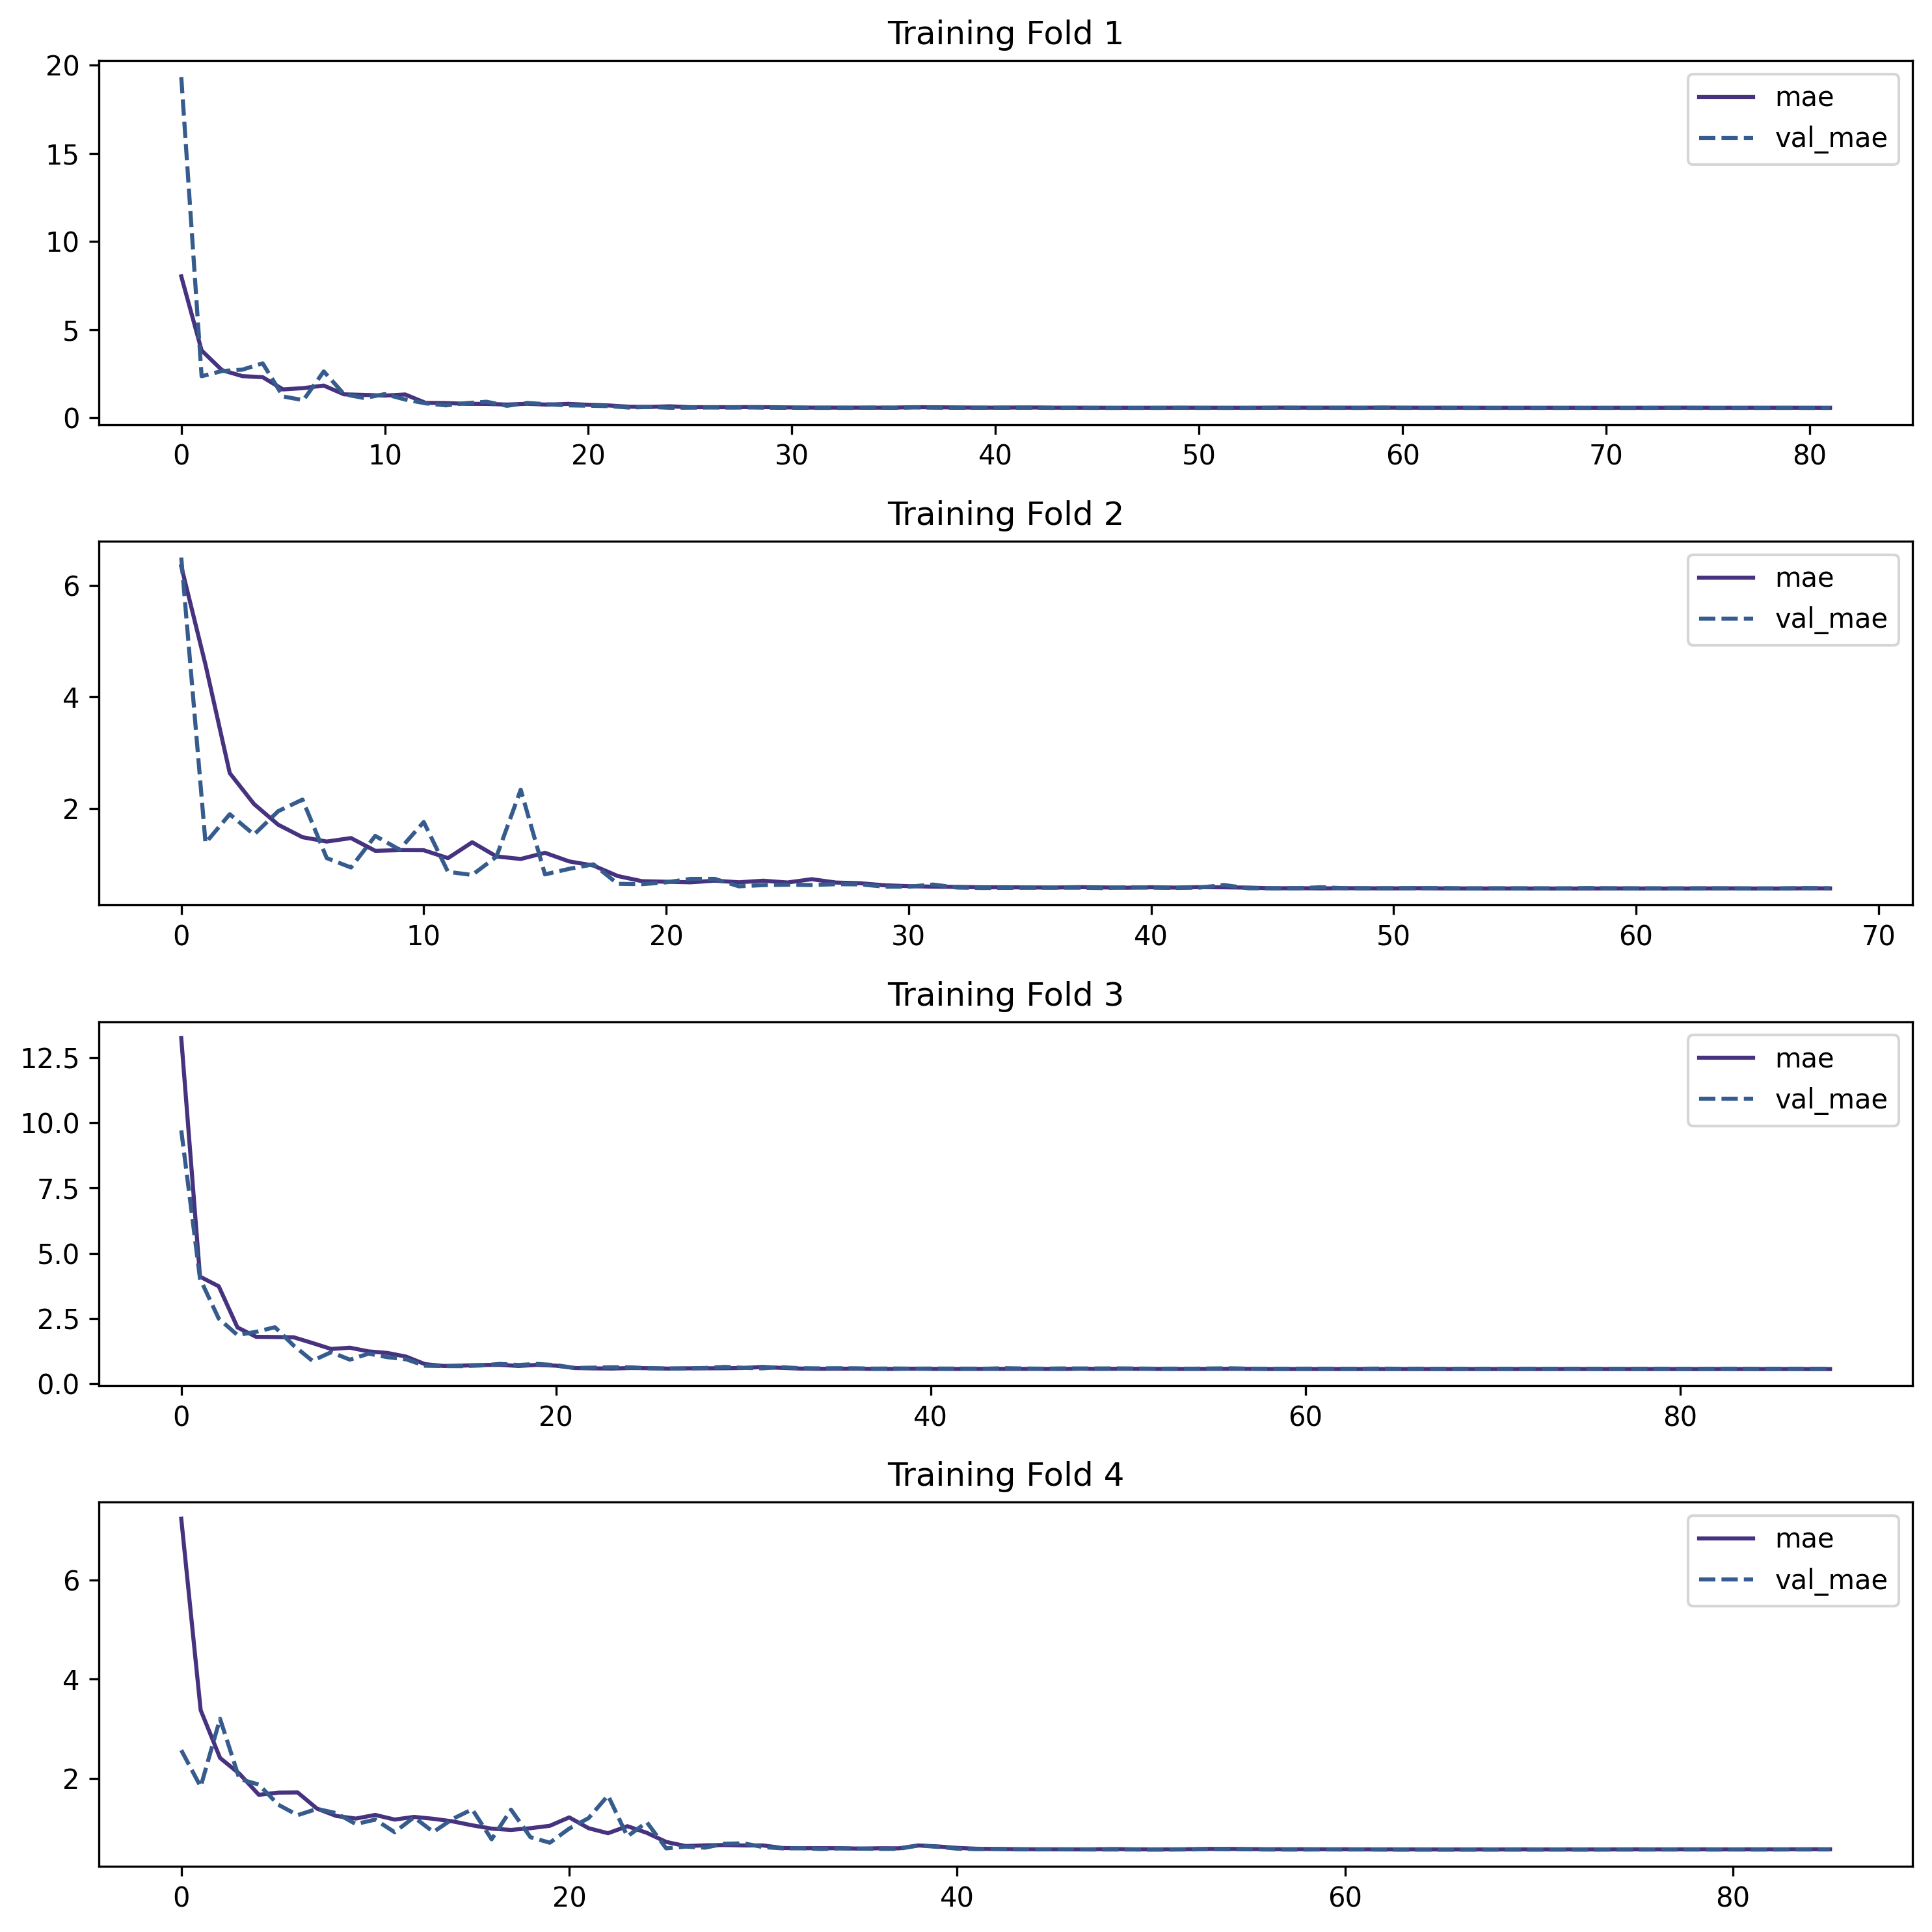

In [21]:
fig,axes = plt.subplots(SPLITS,1,figsize=(10,10),dpi=300)

for ind,his in enumerate(kFold_historys):
    plt.subplot(SPLITS,1,ind+1)
    sns.lineplot(pd.DataFrame(his)[["mae","val_mae"]]);
    plt.gca().set_title(f"Training Fold {ind+1}")


fig.tight_layout()
plt.show()

<div id="6" style="background-color: #89B9AD88; padding: 12px; border-radius: 20px; border: 2px solid black;">
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: black; font-weight: bold; font-size: 32px;">
   📉 Plotting Feature Importance
    </h1>
</div>

In [22]:
def plotImportance(modelName,model):
    history = pd.DataFrame()
    cols = list(X_test.columns)
    cols.remove("VR_Preds")
    history["cols"] = cols
    history["imp"] = model.feature_importances_
    history.sort_values("imp",inplace=True,ascending=False)
    history.reset_index(drop=True)
    plt.figure(figsize=(15,5))
    sns.barplot(x=history["imp"],y=history["cols"],palette="rocket");
    plt.title("Feature Imporance of "+modelName)

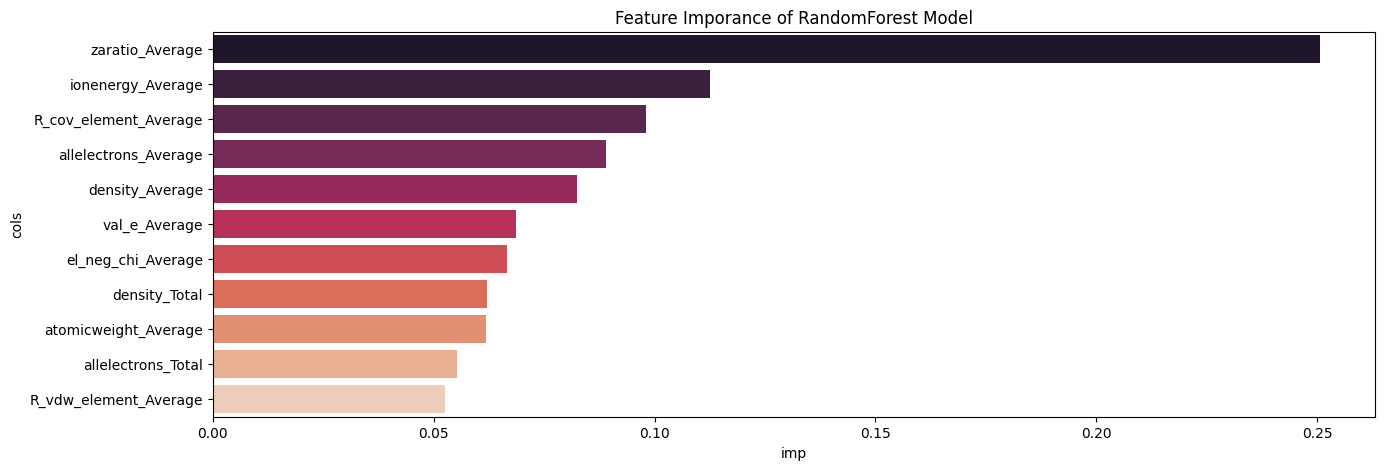

In [23]:
plotImportance("RandomForest Model",rfmodel)

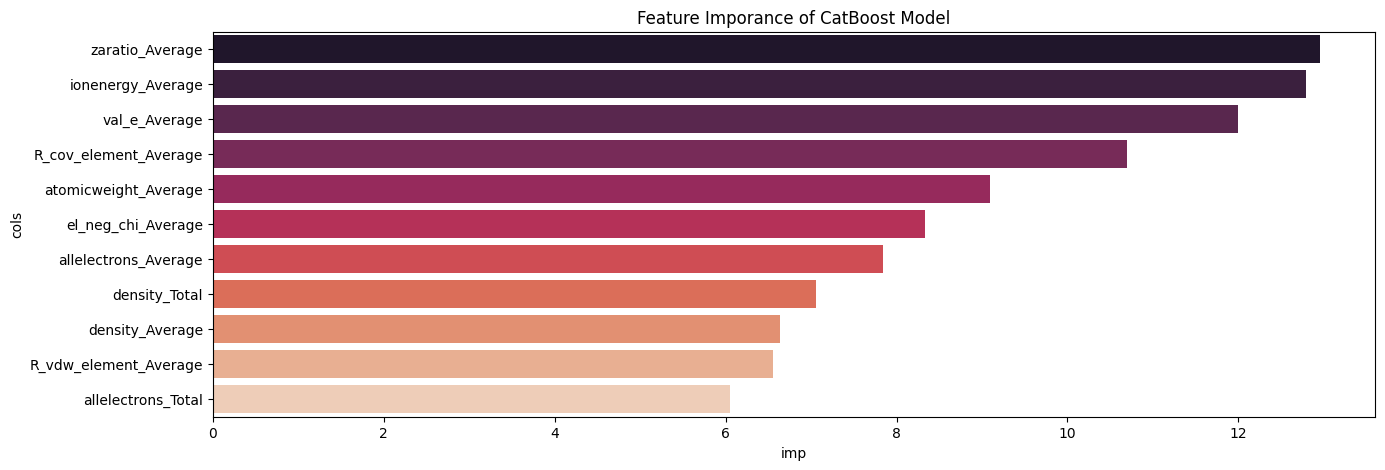

In [24]:
plotImportance("CatBoost Model",catmodel)

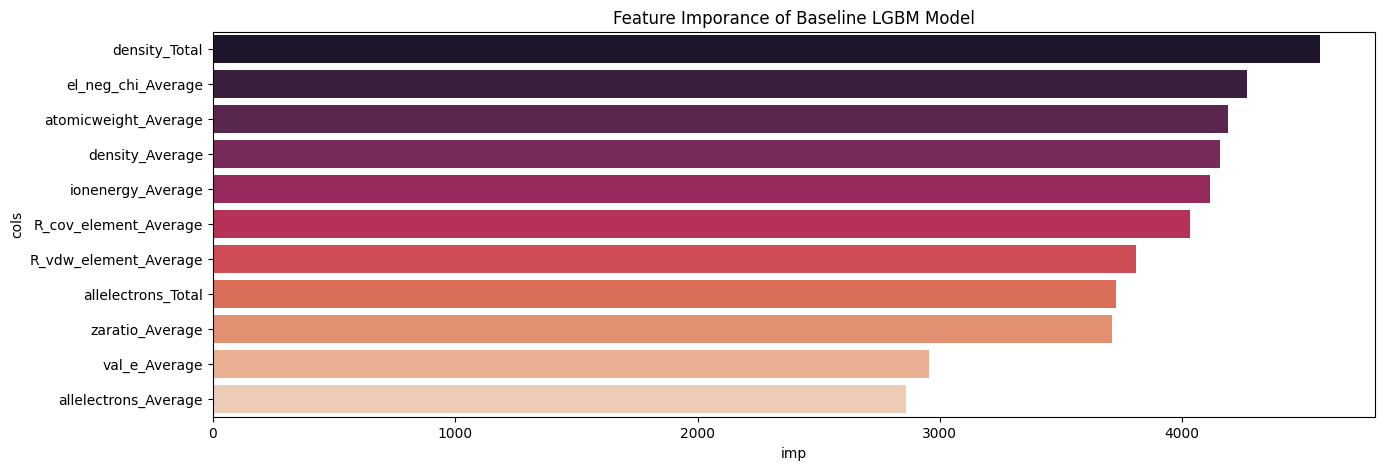

In [25]:
plotImportance("Baseline LGBM Model",lgbmmodel)

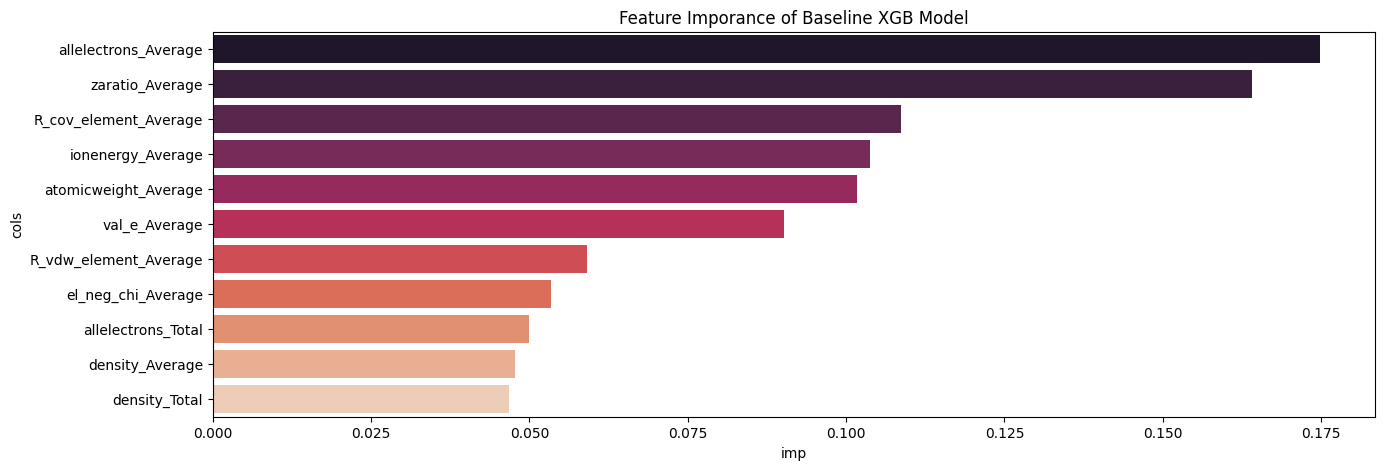

In [26]:
plotImportance("Baseline XGB Model",xgbmodel)

<div id="7" style="background-color: #89B9AD88; padding: 12px; border-radius: 20px; border: 2px solid black;">
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: black; font-weight: bold; font-size: 32px;">
   🏁 Creating 'submission.csv'
    </h1>
</div>

In [27]:
public_work = pd.read_csv("/kaggle/input/regression-with-a-mohs-hardness-dataset/submission.csv")

sample["Hardness"] = sample["Hardness"]/(SPLITS*REPEATS)
sample["Hardness"] = 0.6*public_work["Hardness"] + 0.4*sample["Hardness"]
sample.to_csv("submission.csv",index=False,header=True)

In [28]:
df = pd.DataFrame()
df["preds_vr"] = preds_vr
df["preds"] = sample["Hardness"]
df["public"] = public_work["Hardness"]

df.to_csv("preds.csv",index=False,header=True)

<div id = "8" style="background-color: #89B9AD88; padding: 10px; border-radius: 20px; border: 2px solid black;">
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: black; font-weight: bold; font-size: 22px;">
    👋 Conclusion 
    </h1>
    <h3 style="font-family: 'Garamond', 'Lucida Sans', 'Lucida Sans', sans-serif; text-align: center; color: #505050; line-height: 1.2; font-size: 18px;">
    If you found the notebook helpful, please Upvote the Notebook😊<br>
    If you have any suggestion, feel free to Comment & Tag me<br>
    </h3>
</div>

